# Estimate the diameter (mm) from the amodal and visible masks, using deep learning regression

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
from numpy.linalg import inv
import os
import cv2
import random
import tifffile
from pyexcel_ods import get_data
import csv
import json
from tqdm import tqdm
import time
import seaborn as sns
import pandas as pd

# import some miscellaneous libraries
from utils import visualize
from utils import statistics

# import the libraries that are needed for the deep learning regression
import torch
from torch.autograd import Variable
from torchvision import transforms
import skimage.transform

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog,MetadataCatalog
from detectron2.engine import DefaultTrainer
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10,10

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    plt.show()

## Register the amodal dataset 

In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("broccoli_amodal_test", {}, "datasets/train_val_test_files/mrcnn/test/annotations.json", "datasets/train_val_test_files/mrcnn/test")

In [3]:
broccoli_amodal_test_metadata = MetadataCatalog.get("broccoli_amodal_test")
print(broccoli_amodal_test_metadata)

Metadata(evaluator_type='coco', image_root='datasets/train_val_test_files/mrcnn/test', json_file='datasets/train_val_test_files/mrcnn/test/annotations.json', name='broccoli_amodal_test')


In [4]:
dataset_dicts_test = DatasetCatalog.get("broccoli_amodal_test")

[10/23 10:32:55 d2.data.datasets.coco]: Loaded 487 images in COCO format from datasets/train_val_test_files/mrcnn/test/annotations.json


## Initialize the image inference

In [5]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_orcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (broccoli)

cfg.OUTPUT_DIR = "weights/20201010_broccoli_amodal_visible"
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0007999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.01
cfg.DATASETS.TEST = ("broccoli_amodal_test",)

predictor = DefaultPredictor(cfg)

## Zero-pad and center an image to fixed dimensions

In [6]:
def zeropadding(xyza, dimension=600):
    zp = np.zeros((dimension,dimension,xyza.shape[-1])).astype(np.float32)
    diffx = int(np.divide(dimension - xyza.shape[0], 2))
    diffy = int(np.divide(dimension - xyza.shape[1], 2))
    zp[diffx:diffx+xyza.shape[0], diffy:diffy+xyza.shape[1]] = xyza.astype(np.float32)
    
    return zp

## Image pre-processing

In [7]:
def preprocess(image, image_shape, x_norm, y_norm, z_norm):
    image = skimage.transform.resize(image, image_shape, preserve_range=True)

    width, height = image.shape[:2]
    startx = int((width - 224)/2)
    starty = int((height - 224)/2)
    image = image[startx:startx+224, starty:starty+224, :]

    min_x = float(x_norm[0])
    max_x = float(x_norm[1])
    min_y = float(y_norm[0])
    max_y = float(y_norm[1])
    min_z = float(z_norm[0])
    max_z = float(z_norm[1])
            
    image[:,:,0] = (image[:,:,0] - min_x) / (max_x - min_x)
    image[:,:,1] = (image[:,:,1] - min_y) / (max_y - min_y)
    image[:,:,2] = (image[:,:,2] - min_z) / (max_z - min_z)

    image = np.transpose(image,(2,0,1))
    image = torch.from_numpy(image)

    # transforms.Normalize
    image = transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))(image)
    
    return image

## Initialize the deep learning regression

In [8]:
def init_dl_regression(weightsfile):  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.load(weightsfile)
    model.to(device)
    model.eval()
    
    return model, device

## Run the deep learning regression

In [9]:
def run_dl_regression(model, device, image):   
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    image = image.to(device)

    output = model(image)
    pred = output.data.cpu().numpy()
    prediction = round(float(pred.ravel()), 1)
    
    return prediction

## Estimate the real-world diameter (mm) from the amodal and visible masks, using deep learning regression

In [10]:
# User input needed (directory, file locations, etc):
analysis_name = "orcnn_with_dlregression"
xyzimgdir = "./datasets/train_val_test_files/regression/test"
gtfile = "./datasets/train_val_test_files/groundtruth_measurements_broccoli.ods" ## comment out if there is no ground truth file (also restart the kernel)

100%|██████████| 487/487 [02:44<00:00,  2.96it/s]


173_Untrimmed_Frame_1_127_rgb.png


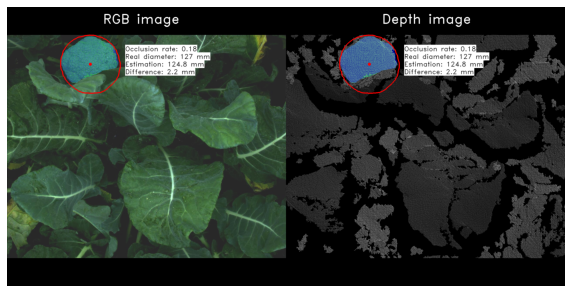

182_Untrimmed_Frame_1_164_rgb.png


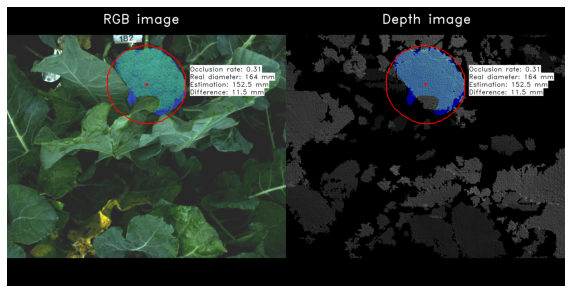

20200713_180453262258_plant1129_rgb_trigger024.png


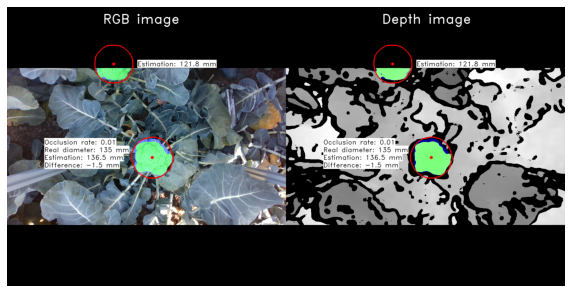

20200819_171041355379_plant1233_rgb_trigger004.png


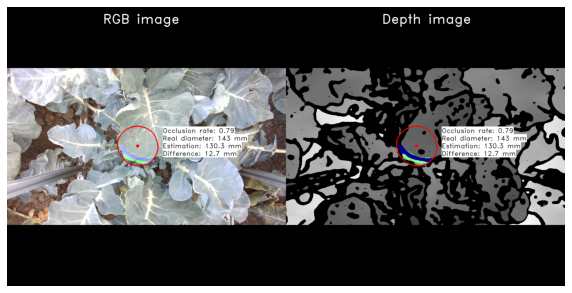

3563_Untrimmed_Frame_8_105_rgb.png


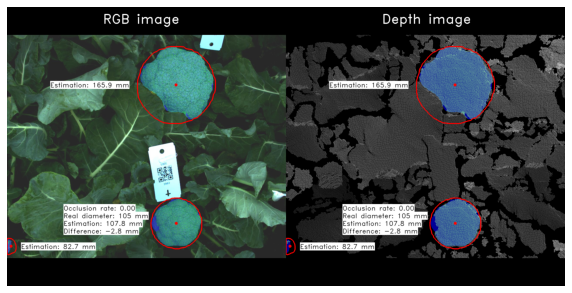

20200713_151200731768_plant1077_rgb_trigger008.png


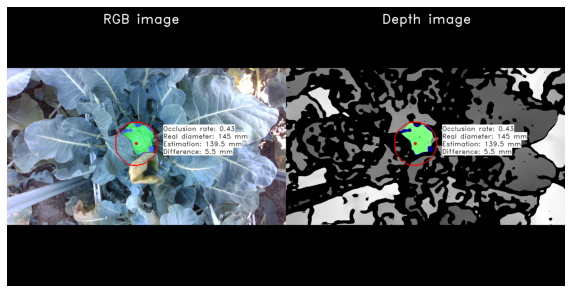

20200713_151205471671_plant1077_rgb_trigger010.png


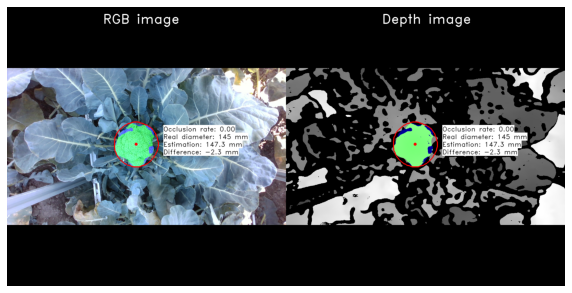

20200819_15205322390_plant1205_rgb_trigger008.png


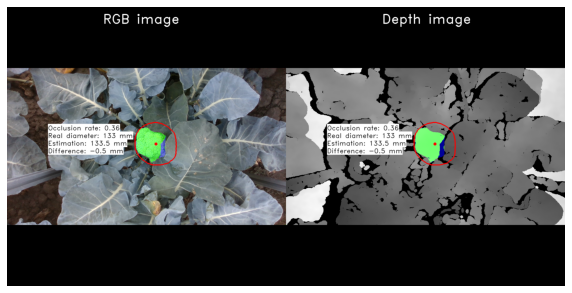

20200819_142052374644_plant1182_rgb_trigger002.png


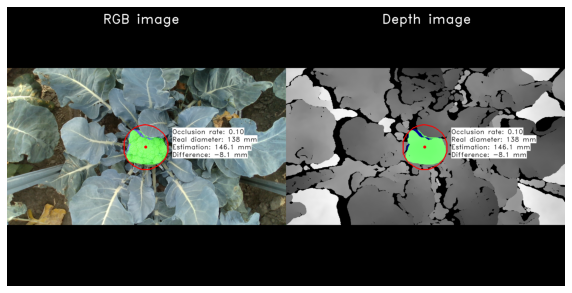

20200819_142101315277_plant1182_rgb_trigger005.png


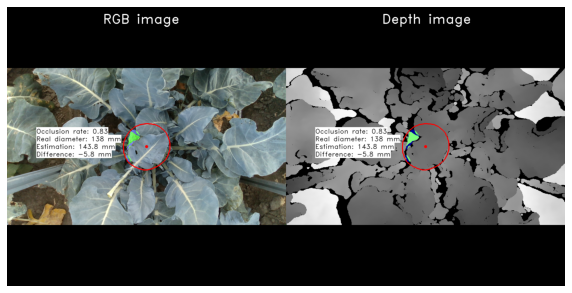

In [11]:
writedir = os.path.join("./results", analysis_name)

if not os.path.exists(writedir):
    os.makedirs(writedir)

try:
    gt = get_data(gtfile)
    gt_file_present = True
except:
    gt_file_present = False

csv_name = 'broccoli_diameter_' + analysis_name + '.csv'
with open(os.path.join(writedir, csv_name), 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['image_id', 'real-world diameter (mm)', 'diameter estimation (mm)', 'difference in diameter (mm)', 'occlusion rate', 'image analysis time (s)'])

diffs = []
vprs = []
gtsizes = []
inference_times = []

ids_visualize = np.random.choice(np.arange(len(dataset_dicts_test)), 10)
random_images = []
random_imagenames = []

for i in tqdm(range(len(dataset_dicts_test))):
    # Load the RGB image
    imgname = dataset_dicts_test[i]["file_name"]
    basename = os.path.basename(imgname)
    img = cv2.imread(imgname)


    # Load the XYZ image
    xyzimgname = basename.replace("rgb", "xyz")
    xyzimgname = xyzimgname.replace(".png", ".tiff")
    xyzimg = tifffile.imread(os.path.join(xyzimgdir, xyzimgname))
    zimg = np.expand_dims(xyzimg[:,:,-1], axis=2)


    # Do the image inference and extract the outputs from Mask R-CNN
    start_time = time.time()
    outputs = predictor(img)
    instances = outputs["instances"].to("cpu")
    classes = instances.pred_classes.numpy()
    scores = instances.scores.numpy()
    boxes = instances.pred_boxes.tensor.numpy()

    # Procedure to check whether we are dealing with ORCNN or MRCNN
    if "pred_visible_masks" in instances._fields:
        amodal_masks = instances.pred_masks.numpy()
        visible_masks = instances.pred_visible_masks.numpy()
    else:
        visible_masks = instances.pred_masks.numpy()


    # Initialize the deep learning regression
    weightsfile = './weights/Dreal_regression_Resnext101_32x8d_unfiltered_xyz_masks_600x600pixels_4channel/epoch_096.pt'
    model, device = init_dl_regression(weightsfile)

    diameters_mm = []
    diameters_pixel = []

    for j in range(boxes.shape[0]):
        # Extract the individual masks and boxes
        bbox = boxes[j]
        amodal_mask = np.expand_dims(amodal_masks[j], axis=2)
        visible_mask = np.expand_dims(visible_masks[j], axis=2)

        # Get the XYZ data of the visible mask
        xyzimg_clip = xyzimg[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2]),:]
        visible_mask_clip = visible_mask[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2]),:]
        xyz_mask = np.multiply(xyzimg_clip, visible_mask_clip)

        # Make a 4-channel image with the XYZ data of the visible mask and the binary amodal mask
        xyza = np.zeros((xyz_mask.shape[0], xyz_mask.shape[1], 4), dtype=np.float32) 
        xyza[:,:,:3] = xyz_mask.astype(np.float32)
        amodal_mask_clip = amodal_mask[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2]),:]
        xyza[:,:,3] = amodal_mask_clip.reshape(xyz_mask.shape[0], xyz_mask.shape[1]).astype(np.float32)

        # Apply zeropadding to resize the final mask to a fixed size
        zp = zeropadding(xyza, 600)

        # Do the image preprocessing so that it can be analyzed by the deep learning regression
        resize_shape = (224, 224)
        x_channel_norm = (-285, 330)
        y_channel_norm = (-260, 285)
        z_channel_norm = (0, 1100)
        regress_image = preprocess(zp, resize_shape, x_channel_norm, y_channel_norm, z_channel_norm)

        # Get the diameter prediction from the deep learning regression
        diameter_mm = run_dl_regression(model, device, regress_image)
        diameters_mm.append(diameter_mm)
        diameters_pixel.append(int(bbox[2]-bbox[0]))


    end_time = time.time()
    elapsed_time = end_time-start_time
    inference_times.append(elapsed_time)


    # Get the ground truth data
    real_diameter = 0
    visible_pixel_ratio = 0
    gt_data_present = False

    if gt_file_present:
        for k in range(1, len(gt['groundtruth_measurements_broccoli'])):
            gt_data = gt['groundtruth_measurements_broccoli'][k]
            if gt_data:
                if gt_data[0] == basename:
                    gt_data_present = True
                    plant_id = gt_data[1]
                    real_diameter = gt_data[2]
                    x_center_gt = gt_data[3]
                    y_center_gt = gt_data[4]
                    visible_pixel_ratio = float(gt_data[5])
                    occlusion_rate = float(1-visible_pixel_ratio)
                    coordinates_broccoli_gt = (x_center_gt, y_center_gt)


    # Find the broccoli head that belongs to the ground truth data
    distances = []

    if np.logical_and(boxes.size > 0, gt_data_present):
        cXs = np.zeros(len(boxes),dtype=np.uint16)
        cYs = np.zeros(len(boxes),dtype=np.uint16)
        for h in range(len(boxes)):
            box = boxes[h]
            x_center = box[0] + ((box[2] - box[0]) / 2)
            y_center = box[1] + ((box[3] - box[1]) / 2)
            cXs[h] = int(x_center)
            cYs[h] = int(y_center)
            distances.append(np.linalg.norm(np.asarray(coordinates_broccoli_gt) - np.asarray((x_center, y_center))))

        idx = np.asarray(distances).argmin()
        diameter = diameters_mm[idx]
    else:
        cXs = []
        cYs = []
        idx = []
        diameter = np.nan


    # Store the randomly selected images in an array 
    if i in ids_visualize:
        img_output, zimg_output = visualize.visualize_results(img, zimg, boxes, visible_masks, amodal_masks, np.array([]), np.array([]), cXs, cYs, diameters_pixel, diameters_mm, idx, str(real_diameter), occlusion_rate)
        img_mosaic = np.hstack((img_output, zimg_output))

        random_imagenames.append(basename)
        random_images.append(img_mosaic)


    # Store the results
    if gt_data_present:
        with open(os.path.join(writedir, csv_name), 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
            csvwriter.writerow([xyzimgname, round(real_diameter, 1), round(diameter, 1), round(np.subtract(real_diameter, diameter), 1), round(occlusion_rate, 3), round(elapsed_time, 3)])

        diffs.append(float(np.subtract(real_diameter, diameter)))
        vprs.append(float(visible_pixel_ratio))
        gtsizes.append(float(real_diameter))
        
        
# Visualize the results
for j in range(len(random_images)):
    image_name = random_imagenames[j]
    print(image_name)
    image = random_images[j]
    imshow(image)

## Summary statistics and graph plotting

Average error when sizing 487 broccoli heads: 6.8 mm
Biggest error when sizing 487 broccoli heads: 52.0 mm


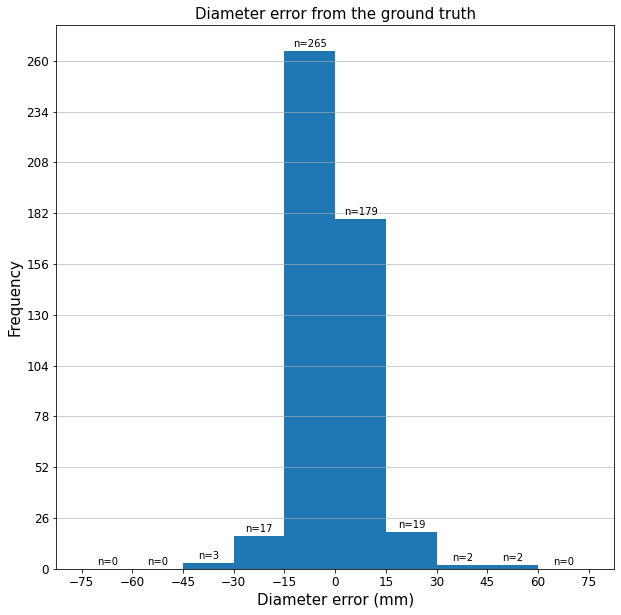

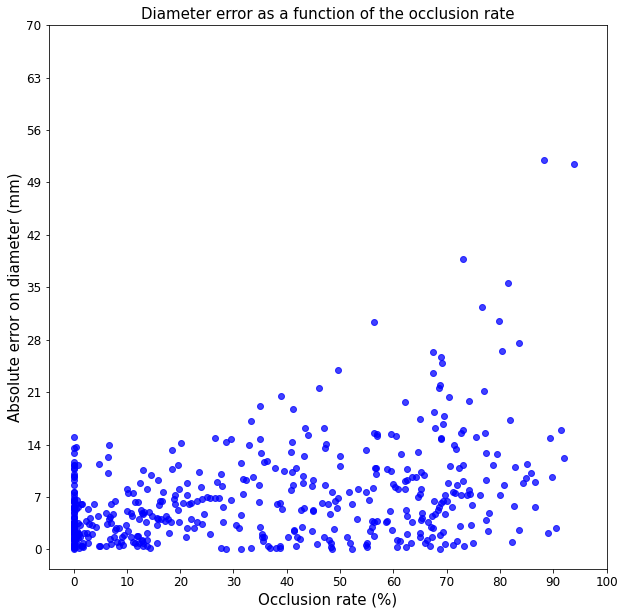

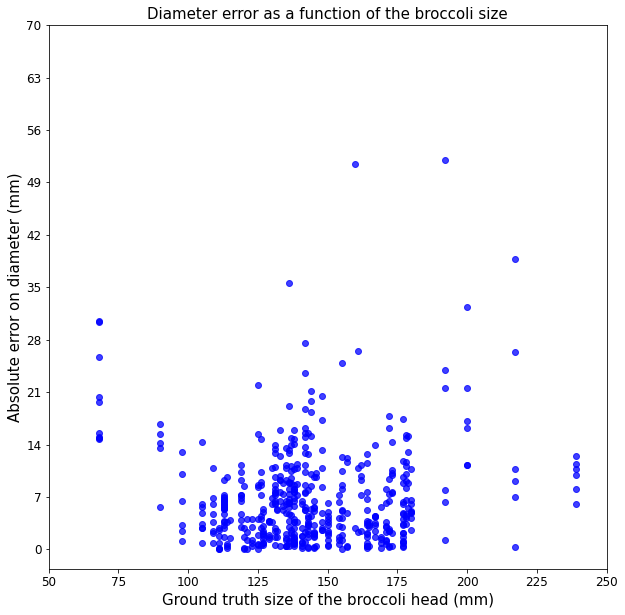

Average image analysis time when sizing 487 broccoli heads: 0.31 s
Highest image analysis time when sizing 487 broccoli heads: 0.42 s


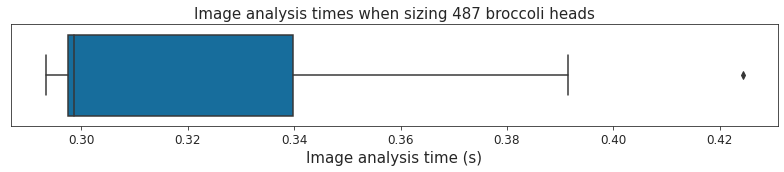

In [12]:
if diffs:
    np.set_printoptions(formatter={'float_kind':'{:f}'.format})

    print("Average error when sizing {0:.0f} broccoli heads: {1:.1f} mm".format(len(dataset_dicts_test), np.average(np.abs(diffs))))
    print("Biggest error when sizing {0:.0f} broccoli heads: {1:.1f} mm".format(len(dataset_dicts_test), np.max(np.abs(diffs))))

    digit_size = 12
    text_size = 15    

    min_bin = statistics.ceil_to_25(-np.max(np.abs(diffs)))
    max_bin = statistics.ceil_to_25(np.max(np.abs(diffs)))
    bin_range = np.abs(max_bin - min_bin)
    
    # Plot the diameter error in a histogram
    statistics.histogram_error(diffs, min_bin, max_bin, bin_range, digit_size, text_size)
    
    
    # Plot the diameter error as a function of the occlusion rate (scatter plot)
    statistics.scatterplot_occlusion(diffs, vprs, max_bin, digit_size, text_size)
    

    # Plot the diameter error as a function of the broccoli size (scatter plot)
    statistics.scatterplot_size(diffs, gtsizes, max_bin, digit_size, text_size)
    
    
    print("Average image analysis time when sizing {0:.0f} broccoli heads: {1:.2f} s".format(len(dataset_dicts_test), np.average(inference_times)))
    print("Highest image analysis time when sizing {0:.0f} broccoli heads: {1:.2f} s".format(len(dataset_dicts_test), np.max(inference_times)))
    
    # Plot the inferences times in a boxplot
    statistics.boxplot_time(len(dataset_dicts_test), inference_times, digit_size, text_size)